In [8]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import os 


def read_image(filename, gray=False):
    im = cv2.imread(filename) 
    return im

def show_images(col, row, images, titles, cmaps=[], scale=2):
    plt.figure(figsize=(row * scale, col * scale))
    cmaps = cmaps if cmaps else [0 for i in images]
    for i in range(len(images)):
        plt.subplot(col, row, i + 1)
        if cmaps[i]: 
            plt.imshow(images[i])
        else:
            plt.imshow(images[i], cmap="gray")
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def invert(img):
    return cv2.bitwise_not(img)

def threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU):
    _, bw_img = cv2.threshold(img, thresh, maxval, type=type)
    return bw_img

def dilate(img, kernel_size=3, iterations=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_img = cv2.dilate(img, kernel, anchor=(-1, -1), iterations=iterations)
    return dilated_img

def erode(img, kernel_size=3, iterations=4):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    erod_img = cv2.erode(img, kernel, anchor=(-1, -1), iterations=iterations)
    return erod_img

def process_image(img, effects, titles=[], verbose=True, col=1, row=-1):
    titles = ["Original"] if not titles else titles
    images = [img]
    prev_img = img  
    for index, effect in enumerate(effects):
        effect_name = effect[0]
        params = ["prev_img"] + effect[1:]
        params_literal = ", ".join(map(str, params)) 
        expression = f"{effect_name}({params_literal})"
        if len(titles) <= index+1 : 
            titles.append(expression)

        prev_img = eval(expression)
        images.append(prev_img)
    # im = cv2.imread(filename)
    # im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    if verbose:
        row = round(len(images)/col) if row == -1 else row
        show_images(col, row, images, titles, scale=3)
    
    return images

In [9]:

def  motion_blur_kernel(kernel_size = 3, angle = 0, standard=True):

    kernel = np.zeros((kernel_size, kernel_size))  # 開一個全黑畫布
    center = kernel_size // 2  # 計算核的中心位置

    cv2.line(kernel, (center, 0), (center, kernel_size - 1), 1, thickness=1)  # 在核中畫一條垂直的直線

    rotation_matrix = cv2.getRotationMatrix2D((center, center), angle, 1)  # 生成旋轉矩陣
    kernel = cv2.warpAffine(kernel, rotation_matrix, (kernel_size, kernel_size))  # 將旋轉矩陣應用到模糊核上
    if standard: 
        kernel /= kernel.sum()
    return kernel

def motion_blur(image, kernel_size, angle):
    """
    對影像添加運動模糊效果，並顯示每一步驟
    :param image: 原始影像 (彩色或灰階)
    :param kernel_size: 模糊核大小
    :param angle: 模糊方向角度
    :return: 添加模糊後的影像
    """
    kernel = np.zeros((kernel_size, kernel_size))  
    center = kernel_size // 2  # 計算核的中心位置
    cv2.line(kernel, (center, 0), (center, kernel_size - 1), 1, thickness=1)  # 在核中畫一條垂直的直線

    # 使用子圖顯示影像
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(kernel, cmap='gray')
    plt.title("Initial Kernel (Line)")
    plt.axis('off')


    # 旋轉模糊核
    rotation_matrix = cv2.getRotationMatrix2D((center, center), angle, 1)  # 生成旋轉矩陣
    kernel = cv2.warpAffine(kernel, rotation_matrix, (kernel_size, kernel_size))  # 將旋轉矩陣應用到模糊核上

    # 標準化模糊核
    kernel /= kernel.sum()

    # 對影像進行濾波
    blurred = cv2.filter2D(image, -1, kernel)

    plt.subplot(1, 3, 2)
    plt.imshow(kernel, cmap='gray')
    plt.title("Rotated Kernel")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(blurred)
    plt.title("Blurred Image")
    plt.axis('off')

    plt.show()

    return blurred, kernel
def wiener_filter(image, kernel, K=0.01):
    """
    使用維納濾波還原模糊影像，並顯示每一步驟
    :param image: 模糊影像 (彩色或灰階)
    :param kernel: 模糊核
    :param K: 噪聲功率比
    :return: 還原後的影像
    """
    result = np.zeros_like(image)
    plt.figure(figsize=(12, 8))

    if len(image.shape) == 2:  # 灰階影像
        kernel_padded = np.pad(kernel, [(0, image.shape[0] - kernel.shape[0]), 
                                        (0, image.shape[1] - kernel.shape[1])], 
                               mode='constant')

        kernel_fft = np.fft.fft2(kernel_padded)
        image_fft = np.fft.fft2(image)

        kernel_conj = np.conj(kernel_fft)
        wiener_result = (kernel_conj / (np.abs(kernel_fft)**2 + K)) * image_fft
        result = np.abs(np.fft.ifft2(wiener_result))

        # Show images and FFT spectrum
        plt.subplot(2, 3, 1)
        plt.imshow(kernel, cmap='gray')
        plt.title("Kernel")
        plt.axis('off')

        plt.subplot(2, 3, 2)
        plt.imshow(image, cmap='gray')
        plt.title("Blurred Image")
        plt.axis('off')

        plt.subplot(2, 3, 3)
        plt.imshow(np.log(1 + np.abs(np.fft.fftshift(image_fft))), cmap='gray')
        plt.title("Shifted FFT of Blurred Image")
        plt.axis('off')

        plt.subplot(2, 3, 4)
        plt.imshow(np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(image)))), cmap='gray')
        plt.title("Shifted FFT of Original Image")
        plt.axis('off')

        plt.subplot(2, 3, 5)
        plt.imshow(np.abs(np.fft.fftshift(kernel_fft)), cmap='gray')
        plt.title("Shifted FFT of Kernel")
        plt.axis('off')

        plt.subplot(2, 3, 6)
        plt.imshow(result, cmap='gray')
        plt.title("Restored Image")
        plt.axis('off')

    else:  # 彩色影像
        for i in range(image.shape[2]):  # 對每個通道處理
            channel = image[:, :, i]
            kernel_padded = np.pad(kernel, [(0, channel.shape[0] - kernel.shape[0]), 
                                            (0, channel.shape[1] - kernel.shape[1])], 
                                   mode='constant')
            kernel_fft = np.fft.fft2(kernel_padded)
            channel_fft = np.fft.fft2(channel)
            kernel_conj = np.conj(kernel_fft)
            wiener_result = (kernel_conj / (np.abs(kernel_fft)**2 + K)) * channel_fft
            result[:, :, i] = np.abs(np.fft.ifft2(wiener_result))

        # Show images and FFT spectrum for each channel
        for i in range(image.shape[2]):

            plt.subplot(4, 3, i + 1)
            plt.imshow(image[:, :, i])
            plt.title(f"Blurred Image Channel {i+1}")
            plt.axis('off')

            plt.subplot(4, 3, i + 4)
            plt.imshow(np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(image[:, :, i])))), cmap='gray')
            plt.title(f"Shifted FFT of Blurred Image Channel {i+1}")
            plt.axis('off')

            plt.subplot(4, 3, i + 7)
            plt.imshow(result[:, :, i])
            plt.title(f"Restored Image Channel {i+1}")

            plt.subplot(4, 3, i + 10)
            plt.imshow(np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(result[:, :, i])))), cmap='gray')
            plt.title(f"Shifted FFT of Restored Image Channel {i+1}")
            plt.axis('off')

            plt.axis('off')

    plt.tight_layout()
    plt.show()
    return result

In [10]:
def mean_filter(image, kernel_size):
    window_size = kernel_size
    edge = window_size // 2
    padded_image = np.pad(image, edge, mode='constant', constant_values=0)
    filtered_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = padded_image[i:i+window_size, j:j+window_size]
            mean_value = np.mean(window)
            filtered_image[i, j] = mean_value
    
    return filtered_image

def median_filter(image, kernel_size):
    window_size = kernel_size
    edge = window_size // 2
    padded_image = np.pad(image, edge, mode="constant", constant_values=0)
    new_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = padded_image[i:i+window_size, j:j+window_size]
            median = np.median(window)
            new_image[i, j] = median

    return new_image

import math

def gaussian_kernel(kernel_size = 3, sigma=1):
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float64)
    center = kernel_size // 2
    sum_val = 0
    
    for i in range(kernel_size):
        for j in range(kernel_size):
            diff = (i - center) ** 2 + (j - center) ** 2
            kernel[i, j] = math.exp(-diff / (2 * sigma ** 2))
            sum_val += kernel[i, j]
    
    # 正規化高斯核，使其所有值加總為1
    kernel /= sum_val
    
    return kernel

def gaussian_filter(image, kernel_size = 3, sigma=1):
    kernel = gaussian_kernel(kernel_size, sigma)
    edge = kernel_size // 2
    padded_image = np.pad(image, edge, mode='constant', constant_values=0)
    filtered_image = np.zeros_like(image)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = padded_image[i:i+kernel_size, j:j+kernel_size]
            # 對當前窗口的像素值與高斯核進行加權求和
            filtered_value = np.sum(window * kernel)

            # 將加權求和的結果分配給過濾圖像中對應的像素
            filtered_image[i, j] = filtered_value
    
    return filtered_image

def histogram_equalization(image, offset=0):
    image_np = np.array(image)  
    histogram, bins = np.histogram(image_np.flatten(), bins=256, range=[0, 256])
    cdf = histogram.cumsum()  
    cdf = cdf / cdf.max()  
    r_max, r_min = 255, 0
    equalized_image_np = np.round(cdf[image_np] * (r_max - r_min)).astype(np.uint8) + offset
    return equalized_image_np

def center_shift(frequency_spectrum):
    """ 將頻譜的低頻移動到中心 """
    N, M = frequency_spectrum.shape
    shifted_spectrum = np.zeros_like(frequency_spectrum, dtype=complex)

    # 分別將四個象限交換
    shifted_spectrum[0:N//2, 0:M//2] = frequency_spectrum[N//2:N, M//2:M]  
    shifted_spectrum[N//2:N, M//2:M] = frequency_spectrum[0:N//2, 0:M//2]  
    shifted_spectrum[0:N//2, M//2:M] = frequency_spectrum[N//2:N, 0:M//2]  
    shifted_spectrum[N//2:N, 0:M//2] = frequency_spectrum[0:N//2, M//2:M]  

    return shifted_spectrum

In [11]:

def apply_sobel(image, kernel):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape

    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1

    output = np.zeros((output_height, output_width))

    for i in range(output_height):
        for j in range(output_width):
            output[i, j] = np.sum(image[i:i+kernel_height, j:j+kernel_width] * kernel).clip(0, 255)

    return output

def show_sobel_result(image, show_edge_xy=False):
    # 讀取圖像

    # 如果是彩色圖像，轉換成灰度圖
    if image.ndim == 3:
        image = image.mean(axis=2)

    # 定義Sobel核
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # 應用Sobel核
    edge_x = apply_sobel(image, sobel_x)
    edge_y = apply_sobel(image, sobel_y)

    # 計算梯度幅度
    magnitude = np.sqrt(edge_x**2 + edge_y**2).clip(0, 255)
    print(magnitude.max())

    # 顯示結果
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1), plt.imshow(image, cmap='gray'), plt.title('Original')
    plt.subplot(1, 2, 2), plt.imshow(magnitude, cmap='gray'), plt.title('Sobel Edge Detection')
    plt.show()

    if show_edge_xy:

        # 顯示結果
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1), plt.imshow(edge_x**2, cmap='gray'), plt.title('edge_x')
        plt.subplot(1, 2, 2), plt.imshow(edge_y**2, cmap='gray'), plt.title('edge_y')
        plt.show()


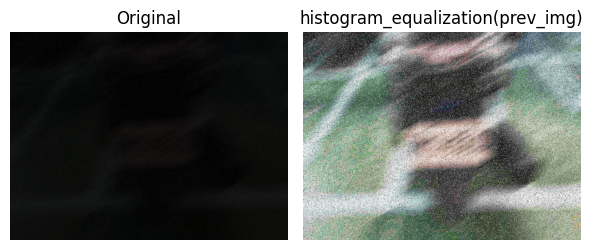

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


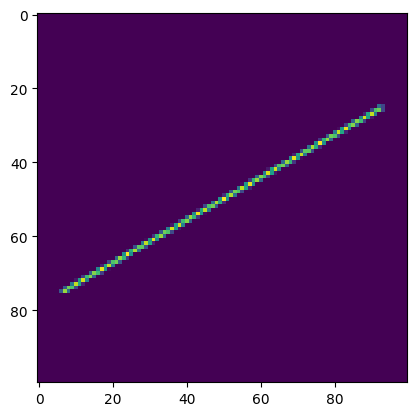

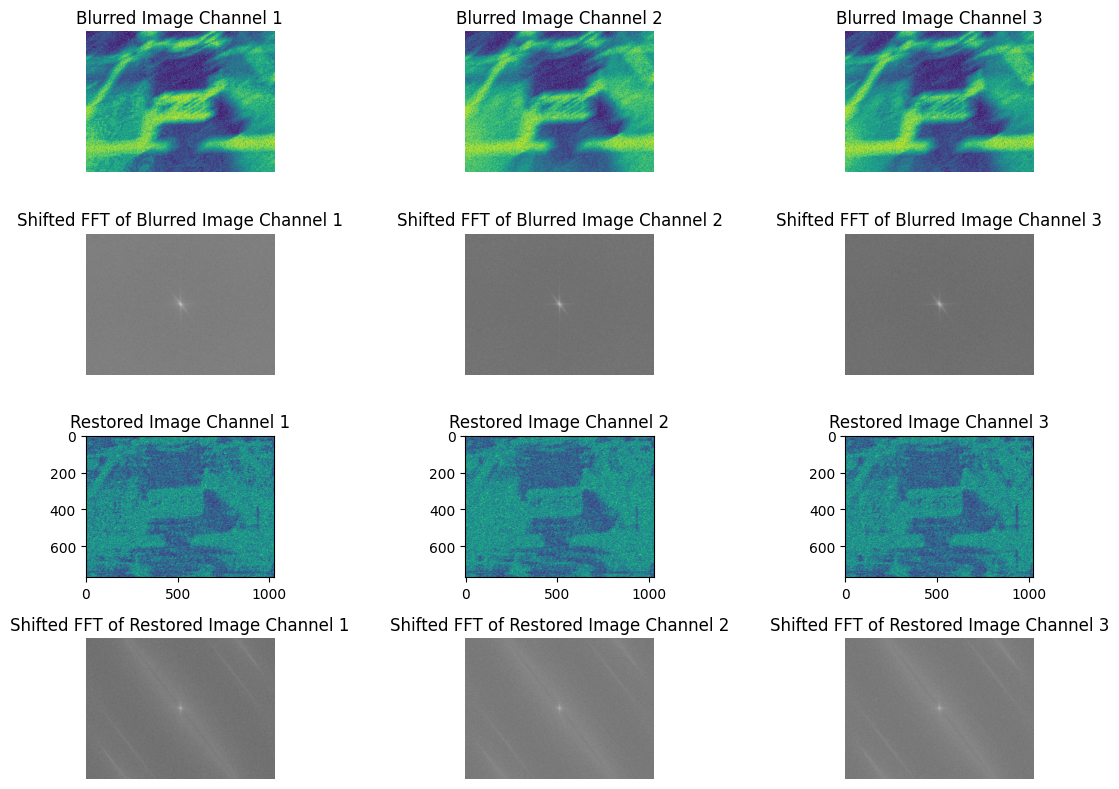

In [12]:
effects = [
            ["histogram_equalization"],
            # ["mean_filter", "kernel_size=10"],
            # ["median_filter", "kernel_size=3"],
            ]


prev_images = process_image(read_image("03_image.jpg"), effects=effects)

blur_kernel = motion_blur_kernel(kernel_size=100, angle=120, standard=True)
print(blur_kernel)


plt.imshow(blur_kernel)

img = wiener_filter(prev_images[-1], kernel=blur_kernel)
# show_sobel_result(prev_images[-1], True)
# blur_kernel = 

# images = process_image(prev_images[-1], effects=effects)

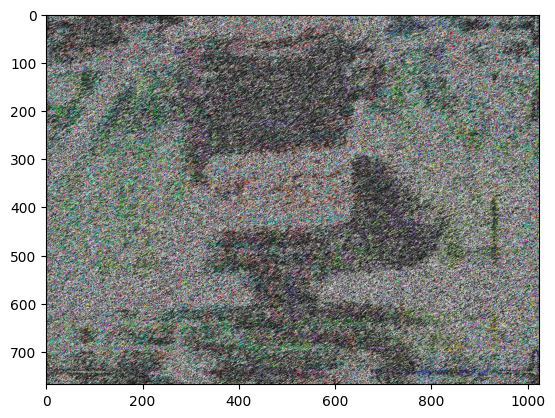

In [13]:

plt.imshow(img)

(100, 100)


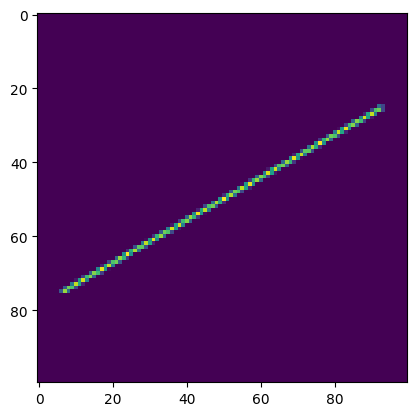

In [14]:

blur_kernel = motion_blur_kernel(kernel_size=100, angle=120, standard=True)
print(blur_kernel.shape)


plt.imshow(blur_kernel)